<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

## Integrated project: Understanding and trusting data (Part 2)
© ExploreAI Academy

In this notebook, we're going to dive into the agricultural dataset to find patterns and try to get insights. We're also stopping for a moment to make sure our data are true and sound by validating it against other data sources. 

⚠️ **Note that this notebook guides us through the activities we need to complete in order to complete the MCQ. There will be 10 MCQs based on the analysis we complete, code we write, visuals we create, and insights we gain.** 

We could be asked to create code, modify code, or interpret some of the results, so we should take our time to do the analysis...

### Instructions

- Complete each step of the analysis.
- Make notes after each output. Try to think about what the numbers say and what it means. 
- Explore the data fully, using all the tools we have learned so far.
- Collaborate with your peers by discussing your insights and sharing your solutions. When it comes to the MCQ, be ready to take it on on your own!

### MCQ checklist: 
- Ensure you have completed all code cells.
- Make sure that you looked at and understood all outputs we discussed today.
- Make sure you completed a crop-by-crop analysis of the data.
- Make sure you took the time to get to know the dataset well.
- Make sure you made thorough notes for each output.

### What to expect in the MCQ
- Questions on interpreting visuals.
- Questions on interpreting data.
- Questions to modify code and discuss/interpret data.
- Questions on how to create visuals or perform analysis.

# Introduction

Fantastic progress so far! Now, let's roll up our sleeves and delve into the heart of our Maji Ndogo project – the exploratory data analysis (EDA) and visualisation. This phase is where our detective hats come on. We're going to sift through our dataset, turning numbers and stats into insightful, visual stories.

Seaborn, our trusty Python visualisation library, will be our main tool here. Think of it as our magnifying glass, helping us zoom in on the nuances of our data. We'll create plots that show relationships between variables like rainfall, pH levels, and temperature. Scatter plots, line graphs, heatmaps – you name it, we'll be creating it. This isn't just about making pretty graphs; it’s about unearthing the hidden patterns and correlations that are key to our agricultural decisions.

But wait, there's a critical step we can't overlook – validating our data. You see, our fields' data need a reality check. We'll be pulling in weather data from nearby stations to compare with our farm measurements. If the temperature, pH, and rainfall data from our farms align closely with these weather stations, we're on the right track. This isn't just about data integrity; it's about ensuring our data reflects the true environmental conditions of Maji Ndogo before we make conclusions or explore the data with AI.

Here’s the task at hand: We'll use weather data from five stations across Maji Ndogo. Each field in our dataset is close to one of these stations, so we also have some data connecting each field in our dataset to the correct weather station. Our goal? To compare and validate key climate measurements. By confirming the accuracy of our data, we increase our confidence in the decisions we make next.

This part of the journey is crucial. We're laying down a solid, trustworthy foundation for our project. Your keen eye for detail and analytical prowess will be invaluable here. Ready to dive into the depths of data validation and visual storytelling? Let's uncover the truths hidden in our numbers and bring precision to our farming strategies in Maji Ndogo.

Onwards and upwards – let's make our data work for us and bring this vision to life!

Saana

# Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float).

- **Longitude:** Geographical longitude of the field in degrees (Float).

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).

- **Ave_temps:** Average temperature in Celsius (Float).

**3. Soil and crop features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float).

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the annual yield.

- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size or crop type. Multiplying this number by the field size and average crop yield will give the Annual_yield.

**Weather_station_data (CSV)**

- **Weather_station_ID:** The weather station the data originated from (Int).

- **Message:** The weather data was captured by sensors at the stations, in the format of text messages (Str).

**Weather_data_field_mapping (CSV)**

- **Field_ID:** The id of the field that is connected to a weather station. This is the key we can use to join the weather station ID to the original data (Int).

- **Weather_station_ID:** The weather station that is connected to a field. If a field has `weather_station_ID = 0` then that field is closest to weather station 0 (Int).

<br>

# Importing and cleaning the data


Alright, let's import the `Maji_Ndogo_farm_survey.db` file again from last time. Make sure to copy the `Maji_Ndogo_farm_survey.db` file into the same directory as this notebook.

In [1]:
import pandas as pd # Importing the Pandas package with an alias, pd
from sqlalchemy import create_engine, text # Importing the SQL interface. If this fails, run !pip install sqlalchemy in another cell.
import matplotlib.pyplot as plt
import seaborn as sns


# Create an engine for the database
engine = create_engine('sqlite:///Maji_Ndogo_farm_survey_small.db') #Make sure to have the .db file in the same directory as this notebook, and the file name matches.

Next up, we test if the connection works:

In [2]:
with engine.connect() as connection:
    result = connection.execute(text("SELECT name FROM sqlite_master WHERE type='table';"))
    for row in result:
        print(row)

('geographic_features',)
('weather_features',)
('soil_and_crop_features',)
('farm_management_features',)


**Expected output:**

`('geographic_features',)`

`('weather_features',)`

`('soil_and_crop_features',)`

`('farm_management_features',)`

And this time, I am using a better SQL query to import the data, so we don't have duplicate `Field_IDs` again.

In [3]:
sql_query = """
SELECT *
FROM geographic_features
LEFT JOIN weather_features USING (Field_ID)
LEFT JOIN soil_and_crop_features USING (Field_ID)
LEFT JOIN farm_management_features USING (Field_ID)
"""

# Create a connection object
with engine.connect() as connection:
    
    # Use Pandas to execute the query and store the result in a DataFrame
    MD_agric_df = pd.read_sql_query(text(sql_query), connection)

    

Cleaning up the data like last time.

In [4]:
MD_agric_df.rename(columns={'Annual_yield': 'Crop_type_Temp', 'Crop_type': 'Annual_yield'}, inplace=True)
MD_agric_df.rename(columns={'Crop_type_Temp': 'Crop_type'}, inplace=True)
MD_agric_df['Elevation'] = MD_agric_df['Elevation'].abs()

# Correcting 'Crop_type' column
def correct_crop_type(crop):
    crop = crop.strip()  # Remove trailing spaces
    corrections = {
        'cassaval': 'cassava',
        'wheatn': 'wheat',
        'teaa': 'tea'
    }
    return corrections.get(crop, crop)  # Get the corrected crop type, or return the original if not in corrections

# Apply the correction function to the Crop_type column
MD_agric_df['Crop_type'] = MD_agric_df['Crop_type'].apply(correct_crop_type)

In [5]:
MD_agric_df

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,8.526684e-02,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,3.996838e-01,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,3.580286e-01,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,2.866871e-01,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,4.319027e-02,1.5,0.832614,wheat,0.555076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,11472,681.36145,-7.358371,-6.254369,Rural_Akatsi,16.213196,885.7,-4.3,33.4,14.55,0.61,Sandy,5.741063,3.286828e-01,1.1,0.609930,potato,0.554482
5650,19660,667.02120,-3.154559,-4.475046,Rural_Kilimani,2.397553,501.1,-4.8,32.1,13.65,0.54,Sandy,5.445833,1.602583e-01,8.7,3.812289,maize,0.438194
5651,41296,670.77900,-14.472861,-6.110221,Rural_Hawassa,7.636470,1586.6,-3.8,33.4,14.80,0.64,Volcanic,5.385873,8.221326e-09,2.1,1.681629,tea,0.800776
5652,33090,429.48840,-14.653089,-6.984116,Rural_Hawassa,13.944720,1272.2,-6.2,34.6,14.20,0.63,Silt,5.562508,6.917245e-10,1.3,0.659874,cassava,0.507595


# Exploratory data analysis

Exploratory data analysis (EDA) is a crucial step in the data science process. The main goals are to understand:
1. What the variables or **feature** variables in our dataset mean.
2. What the distributions of those feature variables are through univariate analysis.
3. What the relationships are between the feature variables, and what the relationships are between the feature variables and our target variable `Standard_yield`. We do this by doing a multivariate analysis.

## Univariate analysis

The first step once our data are cleaned is to look at the dataset as a whole using methods like `df.info()` or `df.describe()`. 

**Task**: Use `df.info()` or `df.describe()` to understand the data we have access to.

In [6]:
#Insert your code here
MD_agric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Annual_yield       5654 non-null   float64
 16  Crop_type          5654 

Ok, first of all, does describe on `Field_ID` tell us anything useful? What about the `Crop_type`? Why isn't the mean of the crop types shown? Can we take the mean of a categorical variable? 

It is really important that we think about the meaning of numbers. If we focus purely on getting an answer, instead of whether it makes sense given the context and what we know about a variable, we’ll often “find” relationships or patterns that are purely coincidental. The mean of `Field_ID` is an example of something that doesn’t actually make sense.

**Make some notes** about the columns and what the **story** is that `.describe()` is telling us:

- **Elevation** – I see... It means that...

- 


<br> 

Next up, let's have a look at the distribution of data in our columns. To do this, we need to use `Seaborn`. Add it to our package imports and create KDE distribution plots of each numeric column. 


To plot multiple visualisations in a single figure in `matplotlib`, we can create a plot with subplots.

⚠️ **Note:** If the multiple plot figure code is too complex, simply plot each column's distribution and make some notes.


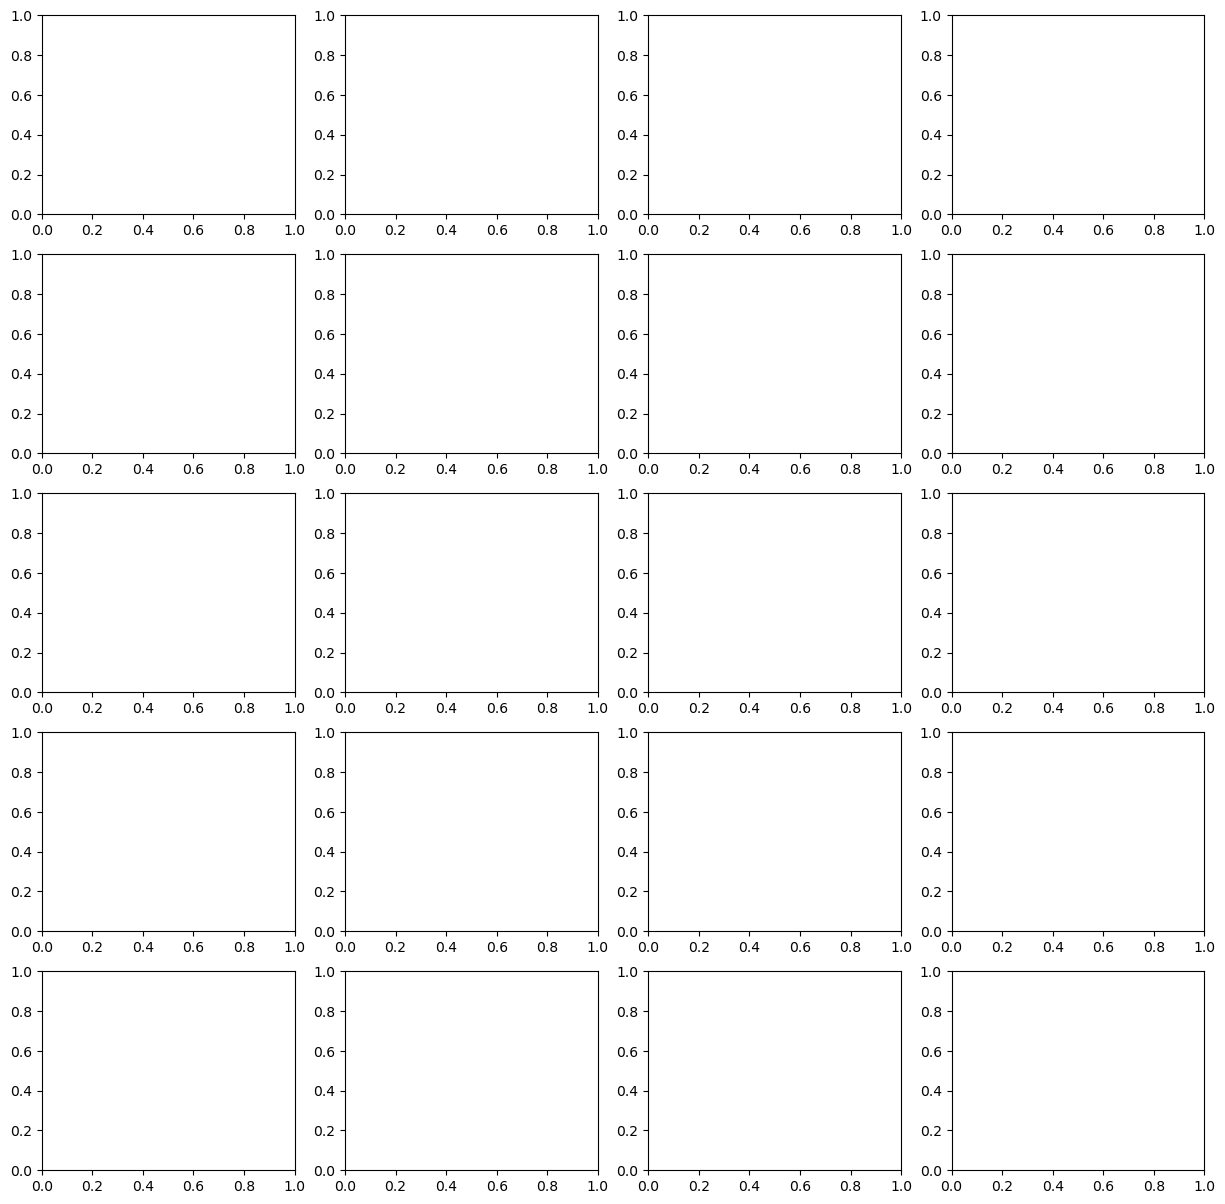

In [7]:
# Setting up a 5x4 grid of plots
fig, axes = plt.subplots(5, 4, figsize=(15, 15))  # Adjust the figure size as needed

This creates plots we can access by `axes[i][j]`. This is pretty hard to iterate through, so we can use a command:

In [8]:
axes = axes.flatten()

This reformats axes to only require one index, `axes[i]`, from 0 to 15 (for each of the 16 plots).
Now we can create a for loop, for i in range(0,15).

In [9]:
for i in range(0,15):
    axes[i]

To plot all of the columns, we can use `enumerate()` over the columns:

In [10]:
#for i, column in enumerate(numerical_columns.columns):
    sns.kdeplot(bins = 5, element = "step", ax = ax[1], data = numerical_colums)

NameError: name 'numerical_columns' is not defined

For each column, we have an `i` value for the plot axes, and a `column` we can use to plot with. Another tip: We may want to see the distribution of the data in relation to the mean value of that column too – we can add these two lines to plot the mean value as a striped, red, vertical line: 

In [11]:
mean_val = MD_agric_df[column].mean()
axes[i].axvline(mean_val, color='red', linestyle='dashed', linewidth=2)

**Task:** Create a single image plot with KDE plots of each column's distribution by completing the code `sns.kdeplot(...`

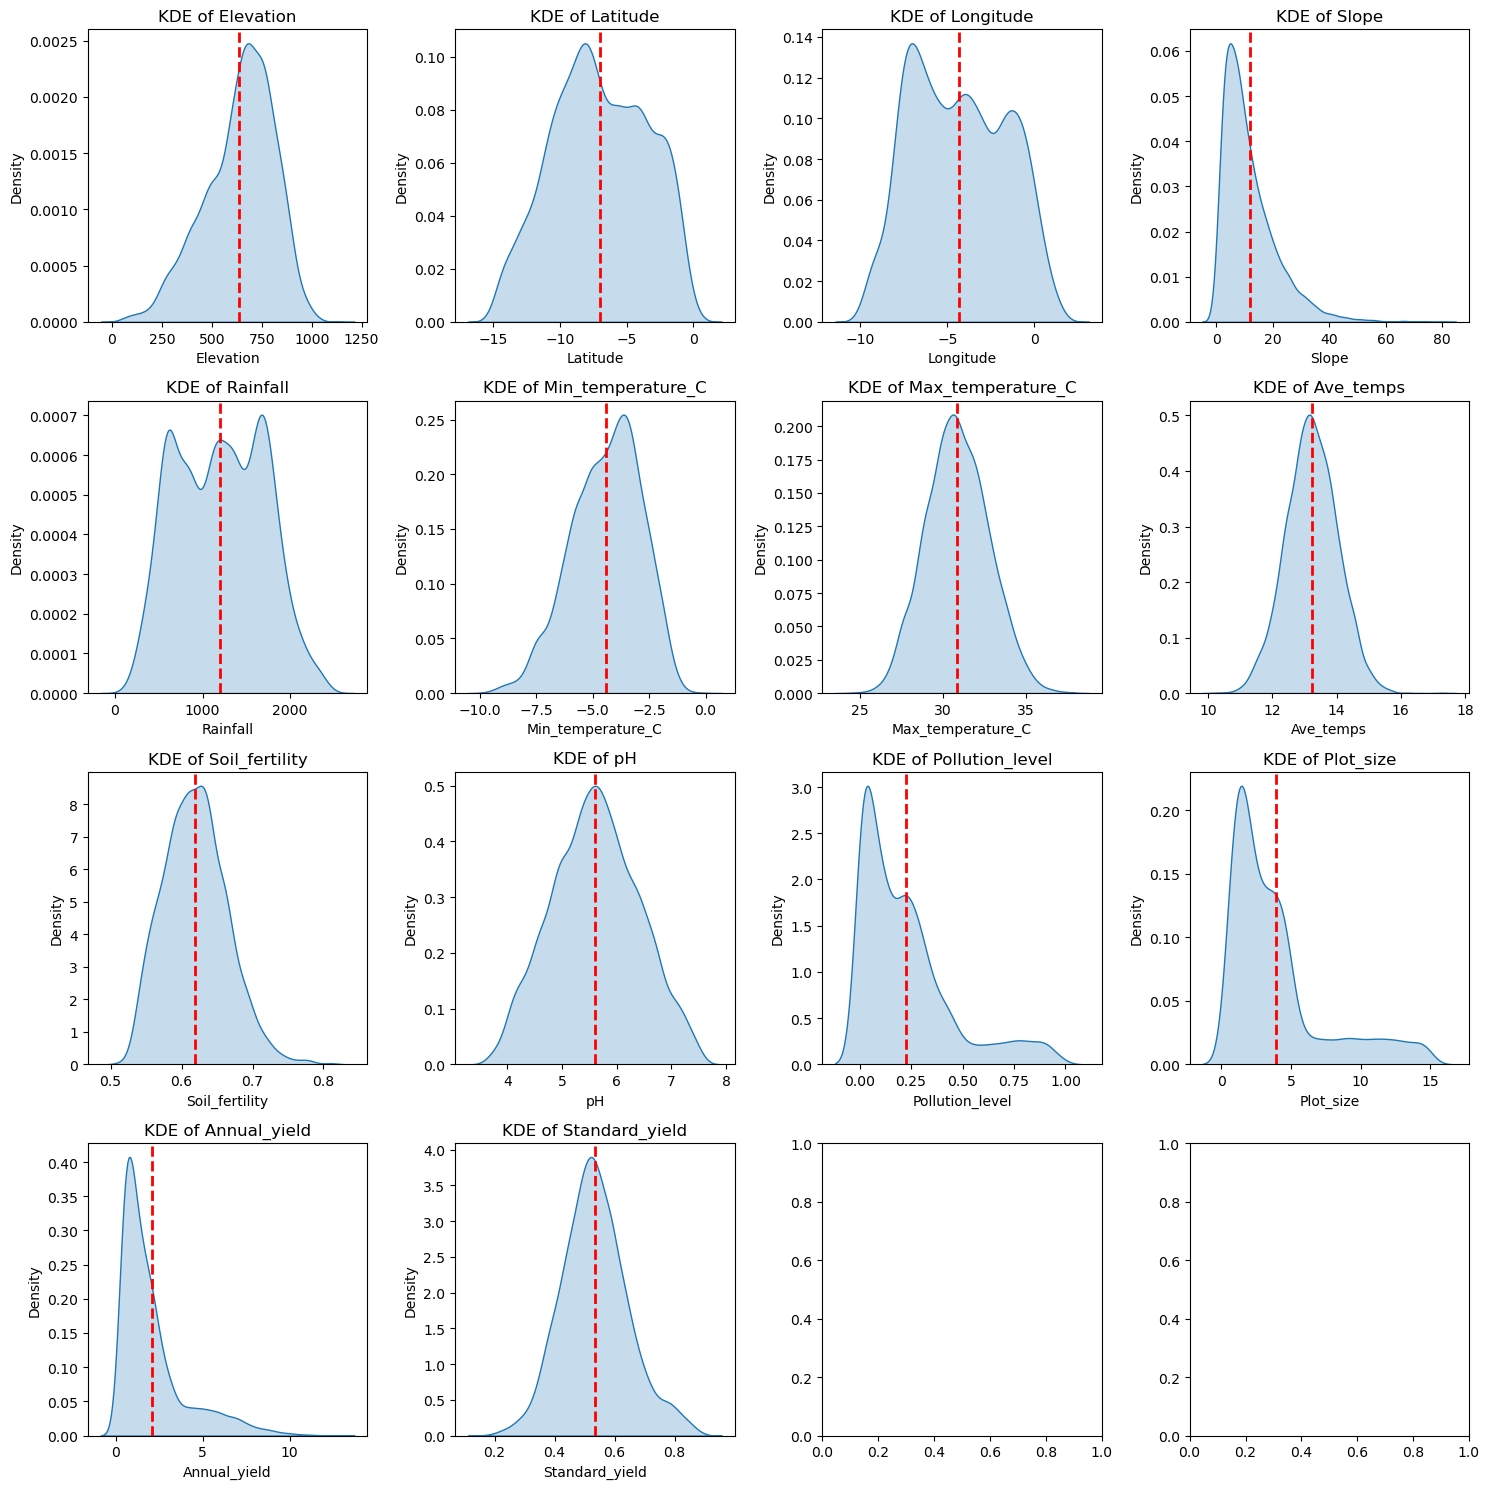

In [13]:
# Create either a single image of KDE plots for each numerical column, or plot each KDE one by one. 

#numerical_columns = MD_agric_df.drop(columns=["Field_ID"])
#numerical_columns = numerical_columns.select_dtypes('number')
# Assuming MD_agric_df is already defined with the simulated data

# Setting up a 5x4 grid of plots
#fig, axes = plt.subplots(4, 4, figsize=(15, 15))  # Adjust the figure size as needed
#axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plotting a KDE for each column in its respective subplot
#for i, column in enumerate(numerical_columns.columns):
    # sns.kdeplot(...

# ANSWER
# Create either a single image of KDE plots for each numerical column, or plot each KDE one by one. 

numerical_columns = MD_agric_df.drop(columns=["Field_ID"])
numerical_columns = numerical_columns.select_dtypes('number')
# Assuming MD_agric_df is already defined with the simulated data

# Setting up a 5x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(15, 15))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plotting a KDE for each column in its respective subplot
for i, column in enumerate(numerical_columns.columns):
    
    sns.kdeplot(MD_agric_df[column], fill=True, ax=axes[i])
    axes[i].set_title(f'KDE of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    mean_val = MD_agric_df[column].mean()
    axes[i].axvline(mean_val, color='red', linestyle='dashed', linewidth=2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Notes:**
- The distribution of the `Slope` variable is skewed a bit to the left, which means the mean value may not be the best measure of central tendency. Most values are below the mean, but there are some extreme values influencing the mean calculation. We should be careful when we use this column in statistical calculations. 

- The KDE of `Rainfall` appears normal but seems to have multiple peaks. This may indicate underlying patterns that are overlapping. We should take a closer look. 

- The distribution of... which means that...

-


<br>

<br>

Let's have a closer look at the `Rainfall` data distribution. We can use the `hue` function in `Seaborn` to separate the data by a category. Let's try segregating the data by `Location` and `Crop_type`.

<Axes: xlabel='Rainfall', ylabel='Density'>

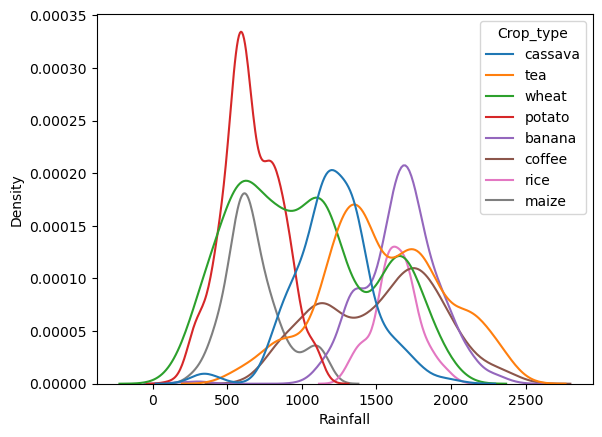

In [14]:
#Create a KDE plot of the Rainfall column using hue.
sns.kdeplot(data = MD_agric_df, x = 'Rainfall', hue= 'Crop_type')

**Notes:** 

**Location** 
- When we split the data by `Location` I see... which means...
- 
**Crop type** 
- When we split the data by `Crop_type` I see... which means...
- 

Answer some of these questions:
Does it rain more in Kilimani than Akatsi? 
Does it rain more in Kilimani than Amanzi?

All the answers lie in the x-axis alone. Akatsi, on average, has a higher rainfall number than Kilimani, and Amanzi's average rainfall is quite similar to Kilimani, so there is no difference really. We can confirm this by grouping our data by `Location` and calculating the means of the `Rainfall` column.

In [15]:
# Calculate the mean rainfall in each province.
MD_agric_df.groupby('Location').mean(numeric_only = True)['Rainfall']

Location
Rural_Akatsi      1584.884457
Rural_Amanzi       723.628958
Rural_Hawassa     1325.941003
Rural_Kilimani     791.352426
Rural_Sokoto      1705.079431
Name: Rainfall, dtype: float64

**Notes:**

 - Amanzi is the province with the lowest average rainfall. Potatoes and maize seem to grow in lower rainfall regions. Is there a connection?

 - Sokoto has ... which means that...
 -

Note that the height of KDE plots is much harder to interpret. It requires a good understanding of what the term `Density` means in this context and is covered well in `Seaborn`'s documentation.

Repeat this analysis for other distributions that look like there are multiple peaks, try to identify more patterns, and try to explain those patterns. 

## Multivariate analysis

In the last step we touched on some multivariate analysis when we noticed that `Location` and `Rainfall` are connected, and that `Rainfall` and `Crop_type` are connected, so let's dive in deeper. Multivariate analysis is all about understanding the relationships our variables have. We can have relationships between numerical columns, numerical and categorical columns, and even between categorical columns, so let's take a look at how we handle each of these cases. 

## Categorical and continuous relationships

One of the tools we can use is a Violin plot that is particularly useful for comparing the distribution of a continuous variable across different levels of a categorical variable. It is similar to the KDE plot, but the distributions are split apart a bit so it is simpler to understand. Note though, often our audience has never encountered a Violin plot before, so make sure to explain what it is and how to interpret it when you present these visualisations. 

**Task:** Create a Violin plot of `Rainfall` distributions for various crop types by completing the code `sns...`

In [ ]:
# We can change the dimensions of our plot with this line of code. Make sure to choose a size that highlights the features of the data.
plt.figure( figsize =(5 ,10))

#Plot a Violin plot
sns...


# ANSWER
# We can change the dimensions of our plot with this line of code. Make sure to choose a size that highlights the features of the data.
plt.figure( figsize =(5 ,10))

#Plot a Violin plot
sns.violinplot(data = MD_agric_df, x = 'Rainfall', y= "Crop_type")

**Notes:**
 - Rice seems to grow mostly where there is about 1600 mm of annual rainfall, while coffee can grow across a wide range of rainfall conditions. Does that mean coffee is a more resilient crop than rice?
 
 - Bananas seem to prefer... so...
 - 

Other options to visualise categorical/continuous data are scatter plots, FacetGrids, or Bubble charts. Be adventurous and try one of these!

## Continuous relationships

The quickest way to visualise smaller datasets, like this one, is to use a `pairplot()`. Create a pairplot of the dataset that colours the data based on which crop type it is.

Note that pairplots take a huge amount of resources, so it may take a while to display.

In [ ]:
remove_columns =['Field_ID','Latitude','Longitude','Annual_yield']

sns.pairplot(MD_agric_df.drop(columns =remove_columns), hue="Crop_type")

**Notes:**
 - There are some linear relationships like `Elevation` vs. `Min_temperature_C`. This means...

 - It seems like the crop types are often clustered together. In a plot of `Standard_yield` vs. `pH` there is a large blob of tea data between `pH` 4 and 6 and `Standard_yield` between 0.6 and 0.8. This means...
 
 - Most relationships have some patterns to them, but it is too complex to identify. For example, `Min_temperature_C` and `Rainfall` seem to be linear but spread apart. The data looks "streaky" so there may be a pattern hidden.
 
 - 

## Categorical relationships

Categorical relationships are also useful to understand. To analyse these we can use a Pandas tool called `crosstab()`. `crosstab()` checks the number of times categorical features co-exist. For example, we saw earlier that Amanzi is the province with the lowest rainfall, and we also saw that most of the maize and potatoes are planted in low-rainfall areas. If we look at the cross tab of 

In [ ]:
pd.crosstab(MD_agric_df['Location'],MD_agric_df['Crop_type'])

From this `crosstab()` we can see that when `Location` is Amanzi, the counts of each field with a specific `Crop_type` are shown. For Amanzi, potatoes, wheat, and maize occur a lot more frequently than the other crops, and as we saw earlier, this is because Amanzi has less rainfall, making these crops more viable. What other relationships can we get from this table?

**Notes:** 

- When The `Location` is `Rural_Kilimani`, potatoes are the most frequent crops, followed by wheat. 

- When the `Location` is `Rural_Sokoto`...

-

## Yield-related relationships

We have found many interesting things in the data looking at the distributions and relationships between variables, but the question we actually have is: **What affects the `Standard_yield`**? Do all crops do better in high-rainfall places? Do all crops grow better on flat terrain where the slope is low? 

To answer this we can look at the last row of the pairplot we made earlier, or we could look at a correlation matrix. 

In Pandas we can easily check if variables are linearly correlated using the `df.corr()` method. It prints out a table containing the Pearson correlation coefficient of each variable with every other variable. A value close to 1 shows us that the variables are perfectly correlated, and a value of -1 shows us that variables are inversely correlated. A value close to 0 means that there is no correlation between the variables, but it does not mean there is no relationship. They could still be correlated through a non-linear relationship.

In [ ]:
MD_agric_df.corr(numeric_only=True)

Since we're only interested in the `Standard_yield`, it will be useful to only look at the `Standard_yield` column and sort the values. 

**Task:** Create a sorted list of correlation coefficients for `Standard_yield` only. 

In [ ]:
# Insert your code here

# ANSWER
MD_agric_df.corr(numeric_only=True)['Standard_yield'].sort_values()

**Notes:**

- `Pollution_level` is inversely correlated (weak) with `Standard_yield`, so when places are polluted, crops produce less.

- `Min_temperature_C` is weakly correlated with `Standard_yield`. So when the minimum temperature is higher, crops produce more. So when it doesn't get too cold, crops grow better.

- No single feature can explain why a crop does well. There are many weak correlations and correlations only look at linear relationships, so features like `Rainfall` that have a low correlation may just not be linearly correlated. 

- 

<br>

The analysis so far is very basic. We're looking at the big picture and trying to understand how all of these features interact with one another to produce good crop yields. We can note, though, that it is complicated. Many things affect these crops. 

It may be beneficial to look at each crop on its own to understand how features interact with a single crop. 

Let's take a closer look at coffee, create a DataFrame that only contains the `coffee` crop type, and analyse the data to understand what makes a coffee crop successful. 

### Coffee

First, we create a DataFrame for only coffee crops, and then look at the pairplot of this DataFrame to understand what affects the coffee crop. By doing this we can remove some of the complexity brought by the different crop types. Each crop type may interact differently with rainfall, pH, and soil type, so by examining each crop category closely we can hopefully gain a bit deeper insight. 

In [ ]:
coffee_df = MD_agric_df.query("Crop_type == 'coffee'")
coffee_df = coffee_df.drop(columns = ['Crop_type','Field_ID','Annual_yield'])

In [ ]:
sns.pairplot(coffee_df)

**Notes:** 

- Coffee crop yield has a positive correlation with rainfall; crop yields are best when there is a lot of rain. 

- Coffee crop yield is higher when the soil is more fertile, so it seems coffee benefits a lot from rich soil. 

- Highly polluted areas lower the crop output of coffee. Pollution has a significant effect on the crop yield.

- 

### Other crop types

**Task:** Analyse the data of other crop types and try to form some understanding of what makes it successful.

# Conclusions

Ok, now take some time to look at all of the results we have in a bigger picture. For example, one of the big takeaways from this analysis is that crops tend to be planted in places where they do well, but not always. Some crops prefer lower rainfall, and are therefore doing well in places with lower rainfall. 

Answer questions like, what makes tea grow well? 

- 

<br>

<br>

# Weather data validation

## Introduction to the data

Ok, so before we dive any deeper into our data, it is a good idea to think about data quality a bit. How do we know the data are accurate and, as a whole, reflect the reality in Maji Ndogo? 

It is critical to be sceptical of the data and the things we learn from it. So, let's validate a portion of our data with another data source. 

There are weather stations scattered across Maji Ndogo that monitor weather-related data in real-time through Internet of Things (IoT) devices. These sensors send their data to a central database. Ideally, the data we get is cleaned, but in this case, we can only access the raw data these sensors bring in, so we have a bit of cleaning to do.

<div align="center" style="font-size: 80%; text-align: center; margin: 0 auto">
    <img src="https://github.com/Explore-AI/Pictures/blob/master/alx_ds_python/Code_challenges/Weather_station_0.png?raw=true" style="display: block; margin-left: auto; margin-right: auto; width: 50%;" />
</div>


In [ ]:
weather_station_df = pd.read_csv("Weather_station_data.csv")

If we have a look at the data, we can see that there are text messages and data about which weather station it came from. Let's have a look at some of these messages:

In [ ]:
pd.set_option('display.max_colwidth', None) # This line will remove column width limits so we can read the contents

weather_station_df

Let's have a look at some of these messages:

In [ ]:
pd.set_option('display.max_colwidth', None)
weather_station_df

The messages all contain a timestamp, which doesn't matter in this analysis, a description of what the measurement was, and the value of that measurement. There are messages about temperatures, rainfall, and air quality. 

But the problem is that the messages are not formatted in a specific way. 

If we look at temperature-related messages, there are two different messages, `Temp. Reading [2023-05-23 09:41:36]: Current 14.53 C.`, `Temperature Read at [2022-09-29 08:22:45]: 13.18C.` and maybe even more. 

We're going to have to use some string methods to get the values and also classify them as rainfall, temperature, or pollution data. 

<br> 

Before we dive in, let's think through what we're trying to do. 

Our main dataset has weather-related data, `Ave_temps`, `Rainfall`, and `Pollution_level` features. If we take the average of these values, we can compare it with the averages of the weather stations. 

The catch is: Which fields do we compare to which station's data? The data below links each field in our main dataset to a weather station:

In [ ]:
weather_station_mapping_df = pd.read_csv("Weather_data_field_mapping.csv")

In [ ]:
weather_station_mapping_df

## The plan of action

So here's the plan.

1. We need to extract all of the measurement types and values from the weather station data. It is important that we check if each message's data are extracted properly before we move on. 

2. Take the average value of each measurement type from the weather data.

3. Join the `weather_station_mapping_df` to `MD_agric_df`, and take the averages of the weather data per station.

4. Compare the averages from the weather data to the averages of the main dataset to confirm whether our data agrees reasonably well with the weather data. 

Think for a second why this could work. If we assume that on average, the farms in a region should experience the same weather as a station somewhere in that region, then their averages should be the same. If the averages do match, we can be pretty confident that the measurements made at the farms represent the reality on the ground, since our independent measurements of weather agreed. 

Hopefully this is the case, so let's get started on extracting the messages. 

## Data extraction

Each of the measurement types will likely have a couple of different ways the data are structured, so we need to find all the different ways messages can be sent, identify patterns in the messages, and use regex to retrieve the value. We'll take on the temperature data together, and then you can complete the rest.

First up, let's look at the messages and find the temperature-related messages first.

In [ ]:
weather_station_df.head(50)

Ok, so we can see that there are messages:
1. `【2022-01-04 21:47:48】温度感应: 现在温度是 12.82C.` – 温度感应 seems to be related to temperature, and the `C` at the end confirms this message is related to temperature.

2. `Temp. Reading [2023-05-23 09:41:36]: Current 14.53 C.` – This one is straightforward, but note that this message has a space between the value and the `C`.

3. `Temperature Read at [2022-01-08 02:54:10]: 12.75C.` – This one has no space between the C and the value again. 

There may be more, but we will build the regex on these three cases and check at the end if we missed any. 



Given these variations, we need a regex pattern that can flexibly capture the temperature value in each case. Here’s how we break it down:

`(\d+(\.\d+)?)`: This is the core part of our pattern. `\d+` matches one or more digits, capturing whole numbers. The `(\.\d+)?` part captures decimal points followed by one or more digits – the `?` makes this decimal part optional, allowing us to match both whole numbers and decimals.

`\s?C`: Next, we account for the possible space (or absence thereof) before the `C`. `\s?` matches zero or one whitespace character – the `?` denotes that the space may or may not be present. Finally, `C` literally matches the character `'C'`.

When we put it all together – `(\d+(\.\d+)?)\s?C` – we get a pattern that will match a number (either whole or decimal), optionally followed by a space, and then a `C`. This pattern covers all our cases, ensuring we accurately extract temperature values from each message type.

Using that regex pattern, we can extract the value, but we also need to classify this as a `Temperature` measurement. We can create a dictionary called `patterns` to hold this pattern and the patterns for the other measurements. The keys will classify the pattern as `Temperature` and the values are the regex pattern we want to match to. Our logic should basically be to check if the `Message` column matches this pattern. If it does, save the key to a `Measurement` column and the value to `Measurement_value`.

In [ ]:
patterns = {
        'Temperature': r'(\d+(\.\d+)?)\s?C'
    }

Let's put this in a function and apply the function to the DataFrame. `extract_measurement` will create a Pandas Series with a tuple inside `(measurement_type,value)`, for example, `('Temperature', 15.6)`. We then use lambda expressions to unpack that tuple into two separate columns.

In [ ]:
import re # Importing the regex pattern
import numpy as np
weather_station_df = pd.read_csv("Weather_station_data.csv")

def extract_measurement(message):
    """
    Extracts a numeric measurement value from a given message string.

    The function applies regular expressions to identify and extract
    numeric values related to different types of measurements such as
    Rainfall, Average Temperatures, and Pollution Levels from a text message.
    It returns the key of the matching record, and first matching value as a floating-point number.
    
    Parameters:
    message (str): A string message containing the measurement information.

    Returns:
    float: The extracted numeric value of the measurement if a match is found;
           otherwise, None.

    The function uses the following patterns for extraction:
    - Rainfall: Matches numbers (including decimal) followed by 'mm', optionally spaced.
    - Ave_temps: Matches numbers (including decimal) followed by 'C', optionally spaced.
    - Pollution_level: Matches numbers (including decimal) following 'Pollution at' or '='.
    
    Example usage:
    extract_measurement("【2022-01-04 21:47:48】温度感应: 现在温度是 12.82C.")
    # Returns: 'Temperature', 12.82
    """
    
    for key, pattern in patterns.items(): # Loop through all of the patterns and check if they match the pattern value.
        match = re.search(pattern, message)
        if match:
            # Extract the first group that matches, which should be the measurement value if all previous matches are empty.
            # print(match.groups()) # Uncomment this line to help you debug your regex patterns.
            return key, float(next((x for x in match.groups() if x is not None)))
    
    return None, None

# The function creates a tuple with the measurement type and value into a Pandas Series
result = weather_station_df['Message'].apply(extract_measurement)

# Create separate columns for 'Measurement' and 'extracted_value' by unpacking the tuple with Lambda functions.
weather_station_df['Measurement'] = result.apply(lambda x: x[0])
weather_station_df['Value'] = result.apply(lambda x: x[1])

In [ ]:
weather_station_df

We can see that the temperature-related measurements are now correctly added. 

Take a moment to look for `Values` like `2022`, `31`, `01`, which may indicate that the regex patterns we used are capturing the timestamp information. 



**Task:** Create regex patterns for the other two measurement types by modifying `patterns`.

In [ ]:
patterns = {
    
    'Temperature': r'(\d+(\.\d+)?)\s?C',
    'Rainfall': # Insert your regex here
    'Pollution_level': # Insert your regex here
    }

# ANSWER: 
patterns = {
    'Rainfall': r'(\d+(\.\d+)?)\s?mm',
     'Temperature': r'(\d+(\.\d+)?)\s?C',
    'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
    }

Search using that pattern, and create the appropriate columns.

In [ ]:
# The function creates a tuple with the measurement type and value into a Pandas Series
result = weather_station_df['Message'].apply(extract_measurement)

# Create separate columns for 'Measurement' and 'extracted_value' by unpacking the tuple with Lambda functions.
weather_station_df['Measurement'] = result.apply(lambda x: x[0])
weather_station_df['Value'] = result.apply(lambda x: x[1])

We can test if we were able to extract values from all the messages if the following code returns an empty DataFrame.

In [ ]:
# Use this line of code to see which messages are not assigned yet.
weather_station_df[(weather_station_df['Measurement'] == None)|(weather_station_df['Value'].isna())]

## Comparing means

### Weather station data preparation

Great, now that our data have been cleaned up, we can calculate the mean `Temperature`, `Rainfall`, and `Pollution_level` for **each** weather station from the weather data. 

**Task:** Calculate the mean `Temperature`, `Rainfall`, and `Pollution_level` by weather station.

In [ ]:
weather_station_means = weather_station_df.groupby(<INSERT YOUR CODE HERE>)['Value'].mean(numeric_only = True)
weather_station_means = weather_station_means.unstack()
weather_station_means

#ANSWER
weather_station_means = weather_station_df.groupby(by = ['Weather_station_ID','Measurement'])['Value'].mean(numeric_only = True)
weather_station_means = weather_station_means.unstack()
weather_station_means

Expected values: 
```python 
Measurement	    Pollution_level	Rainfall	Temperature
Weather_station_ID			
0	            0.352791	        1575.953750	13.403900
1	            0.257333	        577.383910	12.998899
2	            0.043858	        1690.955324	13.179717
3	            0.238190	        905.191397	13.256779
4	            0.128261	        1200.183505	13.188571
```

Now we have a DataFrame where we can retrieve the mean weather measurement values of any weather station using indexing.

<br> 

### Main dataset preparation

Now we need to calculate the mean weather-related data per weather station from our **main dataset**, so we need to merge the mapping data first. 

Merge `MD_agric_df` with `weather_station_mapping_df` to create a `Weather_station_ID` column.

In [ ]:
print("MD_agric_df columns")
print(MD_agric_df.columns)
print("\n")
print("weather_station_mapping_df columns")
print(weather_station_mapping_df.columns)

In [ ]:
# Insert your code here


# ANSWER

MD_agric_df = MD_agric_df.merge(weather_station_mapping_df,on = 'Field_ID', how='left')
MD_agric_df.drop(columns="Unnamed: 0")

Your DataFrame should have **5654 rows × 19 columns**. Make sure to remove duplicate or Unnamed columns.

Then calculate the mean values per weather station.

In [ ]:
MD_agric_df_weather_means = MD_agric_df.groupby("Weather_station").mean(numeric_only = True)[['Pollution_level','Rainfall', 'Ave_temps']]

MD_agric_df_weather_means = MD_agric_df_weather_means.rename(columns = {'Ave_temps':"Temperature"})
MD_agric_df_weather_means

Expected output: 
```python
			Pollution_level	Rainfall	Ave_temps
Weather_station			
0			0.367706	1522.894473	13.393418
1			0.244627	568.445319	13.058085
2			0.043810	1705.834280	13.168364
3			0.271464	931.607860	13.224666
4			0.139913	1168.991800	13.19799
```

### Comparing our datasets

If the format of your `MD_agric_df_weather_means` and `weather_station_means` are correct, then running the code below will check each mean, compare it to the weather data, and print out whether it is within 1.5% of one another.

If you are feeling brave, code out your own solution.

In [ ]:
def within_tolerance_percentage(extracted, original, tolerance_pct):
    """
    Purpose: This function calculates the percentage difference between two values (extracted and original) and checks if this difference is within a specified tolerance percentage (tolerance_pct).
    
    Parameters:
    extracted: A numerical value representing the extracted or observed data point.
    original: A numerical value representing the original or expected data point.
    tolerance_pct: A numerical value representing the tolerance limit as a percentage.
    
    Returns: A Boolean value (True or False). It returns True if the percentage difference between extracted and original is less than or equal to tolerance_pct; otherwise, it returns False.
    
    Calculation: The percentage difference is calculated as abs((extracted - original) / original) * 100.
    """
    # Calculate the percentage difference
    percent_diff = abs((extracted - original) / original) * 100
    # Check if within tolerance
    return percent_diff <= tolerance_pct



def check_means(MD_agric_df_weather_means, weather_station_means):
    """"
    Purpose: This function iterates over two data frames (MD_agric_df_weather_means and weather_station_means), compares the mean values of corresponding entries, and checks if they are within a specified tolerance range using the within_tolerance_percentage function.

    Parameters: 
    MD_agric_df_weather_means: A Pandas DataFrame containing original mean values for various measurements, indexed by weather station IDs.
    weather_station_means: A Pandas DataFrame containing extracted mean values for various measurements, indexed by weather station IDs.

    Functionality: 
    Iterates through each row in weather_station_means. 
    For each row, iterates through each measurement. 
    Retrieves the extracted_mean from weather_station_means and the corresponding original_mean from MD_agric_df_weather_means.
    Uses the within_tolerance_percentage function to check if the extracted_mean is within the specified tolerance percentage of the original_mean.
    Keeps count of how many measurements are within and outside the tolerance range (true_count and false_count respectively).
    Prints detailed information for each measurement, including the weather station ID, measurement name, extracted mean, original mean, and whether it is within specification.

    Outputs: At the end, the function prints the total count of measurements that are within (True) and outside (False) the tolerance range.

    Note: The function assumes the existence of a global variable tolerance_pct that specifies the tolerance percentage.
    These functions appear to be particularly useful in data validation processes, where comparing data sets and ensuring their consistency within certain limits is crucial.
    """
    true_count = 0
    false_count = 0
    for index, row in weather_station_means.iterrows():

        print(f"Weather Station ID: {index}")
        for measurement in row.index:
            print (measurement)
            extracted_mean = row[measurement]
            original_mean = MD_agric_df_weather_means.loc[index, measurement]
            within_spec = within_tolerance_percentage(extracted_mean, original_mean, tolerance_pct)
            if  within_spec == True:
                true_count +=1
            else:
                false_count +=1
            print(f"  Measurement: {measurement}, Extracted Mean: {extracted_mean}, Original Mean: {original_mean}, Within Spec: {within_spec}")
            print(" ")
    print(f"True: {true_count}, False: {false_count}")



# Example tolerance percentage (e.g., 5%)
tolerance_pct = 1.5

check_means(MD_agric_df_weather_means, weather_station_means)

Expected output:
```python
Weather Station ID: 0
Pollution_level
  Measurement: Pollution_level, Extracted Mean: 0.35279069767441856, Original Mean: 0.36770623143001924, Within Spec: False
 
Rainfall
  Measurement: Rainfall, Extracted Mean: 1575.9537500000001, Original Mean: 1522.8944727272726, Within Spec: False
 
Temperature
  Measurement: Temperature, Extracted Mean: 13.4039, Original Mean: 13.393418181818182, Within Spec: True
 
Weather Station ID: 1
Pollution_level
  Measurement: Pollution_level, Extracted Mean: 0.2573333333333333, Original Mean: 0.24462714245217726, Within Spec: False
 
Rainfall
  Measurement: Rainfall, Extracted Mean: 577.3839097744361, Original Mean: 568.4453191489362, Within Spec: False
 
Temperature
  Measurement: Temperature, Extracted Mean: 12.998899082568807, Original Mean: 13.058085106382979, Within Spec: True
 
Weather Station ID: 2
Pollution_level
  Measurement: Pollution_level, Extracted Mean: 0.043858267716535435, Original Mean: 0.043809732976173035, Within Spec: True
 
Rainfall
  Measurement: Rainfall, Extracted Mean: 1690.9553237410073, Original Mean: 1705.834280117532, Within Spec: True
 
Temperature
  Measurement: Temperature, Extracted Mean: 13.179716981132074, Original Mean: 13.168364348677766, Within Spec: True
 
Weather Station ID: 3
Pollution_level
  Measurement: Pollution_level, Extracted Mean: 0.23818965517241378, Original Mean: 0.27146439734566075, Within Spec: False
 
Rainfall
  Measurement: Rainfall, Extracted Mean: 905.1913970588236, Original Mean: 931.6078595317725, Within Spec: False
 
Temperature
  Measurement: Temperature, Extracted Mean: 13.256778523489933, Original Mean: 13.224665551839465, Within Spec: True
 
Weather Station ID: 4
Pollution_level
  Measurement: Pollution_level, Extracted Mean: 0.1282608695652174, Original Mean: 0.13991297519041454, Within Spec: False
 
Rainfall
  Measurement: Rainfall, Extracted Mean: 1200.1835051546393, Original Mean: 1168.9918003565062, Within Spec: False
 
Temperature
  Measurement: Temperature, Extracted Mean: 13.188571428571429, Original Mean: 13.197994652406416, Within Spec: True
 
True: 7, False: 8
```

Oh no... `True: 7, False: 8`, which means some of the values don't match. Does this mean our data are not a true reflection of reality?

This is a bit of a disaster. I am going to think about this a bit, you do the same, and when we meet again we can share ideas.

Until next time.

Saana

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>